# 003. Web Search Rag with LangGraph

## Configuration

In [ ]:
from dotenv import load_dotenv
from tools import logging
import nest_asyncio
import os

load_dotenv(override=True)
nest_asyncio.apply()

logging.langsmith("web-search-RAG")

In [2]:
pip install -r requirements.txt

  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.2
    Uninstalling protobuf-6.33.2:
      Successfully uninstalled protobuf-6.33.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
protoc-gen-openapiv2 0.0.1 requires protobuf>=4.21.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow 2.20.0 requires protobuf>=5.28.0, but you have protobuf 3.20.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


# PDF Retrieval

PDF Loader Rank (The lower, the better)

| | PDFMiner | PDFPlumber | PyPDFium2 | PyMuPDF | PyPDF2 |
|----------|:---------:|:----------:|:---------:|:-------:|:-----:|
| Medical  | 1         | 2          | 3         | 4       | 5     |
| Law      | 3         | 1          | 1         | 3       | 5     |
| Finance  | 1         | 2          | 2         | 4       | 5     |
| Public   | 1         | 1          | 1         | 4       | 5     |
| Sum      | 5         | 5          | 7         | 15      | 20    |

Source: [AutoRAG Medium Blog](https://velog.io/@autorag/PDF-%ED%95%9C%EA%B8%80-%ED%85%8D%EC%8A%A4%ED%8A%B8-%EC%B6%94%EC%B6%9C-%EC%8B%A4%ED%97%98#%EC%B4%9D%ED%8F%89)

### LlamaParser
- Support for a wide range of document formats, including PDF, Word, PowerPoint, and Excel
- Advanced extraction capabilities for complex tables and images
- Multilingual document processing support

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter, CharacterTextSplitter
from llama_parse import LlamaParse
from llama_index.core import SimpleDirectoryReader
from langchain.retrievers import BM25Retriever, EnsembleRetriever, ContextualCompressionRetriever
from langchain.retrievers.document_compressors import FlashrankRerank
from langchain_openai import ChatOpenAI


# 1. LlamaParse Loader
parser = LlamaParse(
    result_type="markdown",  
    num_workers=8,  
    verbose=True,
    language="en",
)

file_extractor = {".pdf": parser}

documents = SimpleDirectoryReader(
    input_files=["data/Deepseek-r1.pdf"],
    file_extractor=file_extractor,
).load_data()

documents = [doc.to_langchain_format() for doc in documents]

for idx, doc in enumerate(documents):
    doc.metadata["page"] = idx + 1
    doc.metadata["source"] = doc.metadata.get(
        "file_path", "data/Deepseek-r1.pdf"
    )

print(f"Loaded documents count: {len(documents)}")
for i, doc in enumerate(documents):
    print(f"\n--- Document {i} ---")
    print(doc.metadata)


Started parsing the file under job_id f36bcfa4-adbc-4229-bf1d-7d69f0786cdd
Loaded documents count: 22

--- Document 0 ---
{'file_path': 'data/Deepseek-r1.pdf', 'file_name': 'Deepseek-r1.pdf', 'file_type': 'application/pdf', 'file_size': 1312189, 'creation_date': '2025-12-07', 'last_modified_date': '2025-12-05', 'page': 1, 'source': 'data/Deepseek-r1.pdf'}

--- Document 1 ---
{'file_path': 'data/Deepseek-r1.pdf', 'file_name': 'Deepseek-r1.pdf', 'file_type': 'application/pdf', 'file_size': 1312189, 'creation_date': '2025-12-07', 'last_modified_date': '2025-12-05', 'page': 2, 'source': 'data/Deepseek-r1.pdf'}

--- Document 2 ---
{'file_path': 'data/Deepseek-r1.pdf', 'file_name': 'Deepseek-r1.pdf', 'file_type': 'application/pdf', 'file_size': 1312189, 'creation_date': '2025-12-07', 'last_modified_date': '2025-12-05', 'page': 3, 'source': 'data/Deepseek-r1.pdf'}

--- Document 3 ---
{'file_path': 'data/Deepseek-r1.pdf', 'file_name': 'Deepseek-r1.pdf', 'file_type': 'application/pdf', 'file_si

In [55]:
print(documents[8].page_content)



# Question:

If 𝑎 > 1, then the sum of the real solutions of  𝑎 − √𝑎 + 𝑥 = 𝑥 is equal to

# Response:

<think>      √</think>

To solve the equation  𝑎 −    𝑎 + 𝑥 = 𝑥, let’s start by squaring both · · ·

√︁  𝑎 − √𝑎 + 𝑥 2 = 𝑥2 =⇒ 𝑎 − √𝑎 + 𝑥 = 𝑥2.

Rearrange to isolate the inner square root term:

(𝑎 − 𝑥2)2 = 𝑎 + 𝑥 =⇒ 𝑎2 − 2𝑎𝑥2 + (𝑥2)2 = 𝑎 + 𝑥 =⇒ 𝑥4 − 2𝑎𝑥2 − 𝑥 + (𝑎2 − 𝑎) = 0

Wait, wait. Wait. That’s an aha moment I can flag here.

Let’s reevaluate this step-by-step to identify if the correct sum can be · · ·

We started with the equation:

𝑎 − √𝑎 + 𝑥 = 𝑥

First, let’s square both sides:

𝑎 − √𝑎 + 𝑥 = 𝑥2    =⇒ √𝑎 + 𝑥 = 𝑎 − 𝑥2

Next, I could square both sides again, treating the equation: · · ·

# Table 3

| An interesting “aha moment” of an intermediate version of DeepSeek-R1-Zero. The model learns to rethink using an anthropomorphic tone. This is also an aha moment for us, allowing us to witness the power and beauty of reinforcement learning.

# Drawback of DeepSeek-R1-Zero

Although 

In [54]:
print(documents[12].page_content)


# 3.1. DeepSeek-R1 Evaluation

| Benchmark (Metric)              | Claude-3.5-             | GPT-4o | DeepSeek | OpenAI | OpenAI | DeepSeek |      |
| ------------------------------- | ----------------------- | ------ | -------- | ------ | ------ | -------- | ---- |
| Architecture                    | -                       | -      | MoE      | -      | -      | MoE      |      |
| # Activated Params              | -                       | -      | 37B      | -      | -      | 37B      |      |
| # Total Params                  | -                       | -      | 671B     | -      | -      | 671B     |      |
| MMLU (Pass\@1)                  | 88.3                    | 87.2   | 88.5     | 85.2   | 91.8   | 90.8     |      |
| MMLU-Redux (EM)                 | 88.9                    | 88.0   | 89.1     | 86.7   | -      | 92.9     |      |
| MMLU-Pro (EM)                   | 78.0                    | 72.6   | 75.9     | 80.3   | -      | 84.0     |      |
| DROP (3-shot F1)      

### Embedding Models

| MODEL                  | PAGES PER DOLLAR | PERFORMANCE ON MTEB EVAL | MAX INPUT |
|------------------------|------------------|---------------------------|-----------|
| text-embedding-3-small | 62,500           | 62.3%                     | 8191      |
| text-embedding-3-large | 9,615            | 64.6%                     | 8191      |
| text-embedding-ada-002 | 12,500           | 61.0%                     | 8191      |

In [ ]:

# 2. Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)
split_docs = text_splitter.split_documents(documents)

# 3. Embeddings 
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# 4. Vector DB: FAISS
db = FAISS.from_documents(split_docs, embeddings)

# 5. Retrieval
# 5-1. Ensemble Retrieval

# bm25 retriever
bm25_retriever = BM25Retriever.from_documents(
    split_docs,
)
bm25_retriever.k = 10  # BM25Retriever

# FAISS retriever
embedding = OpenAIEmbeddings()  
faiss_vectorstore = FAISS.from_documents(
    split_docs,
    embedding,
)

faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 10})

# Ensemble retriever
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever],
    weights=[0.3, 0.7],
)

### Reranker Model

<p align="left">
  <img src="images/reranker-benchmark.png" width="800">
</p>

In [ ]:
# 5-2. Rerank Model

llm = ChatOpenAI(temperature=0)
compressor = FlashrankRerank(
    model="ms-marco-MultiBERT-L-12",
    top_n=10)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=ensemble_retriever
)

In [7]:
# query = "What is DeepSeek-R1-Zero?"
# compression_retriever.invoke(query)[0].page_content
# compression_retriever.invoke(query)[0].metadata

In [8]:
query = "What is DeepSeek-R1-Zero?"

compression_retriever_result = compression_retriever.invoke(query)
ensemble_result = ensemble_retriever.invoke(query)
bm25_result = bm25_retriever.invoke(query)
faiss_result = faiss_retriever.invoke(query)

print("[compression Retriever]")
for doc in compression_retriever_result:
    print(f"Content: {doc.page_content}")
    print()

print("[Ensemble Retriever]")
for doc in ensemble_result:
    print(f"Content: {doc.page_content}")
    print()

print("[FAISS Retriever]")
for doc in faiss_result:
    print(f"Content: {doc.page_content}")
    print()

print("[BM25 Retriever]")
for doc in bm25_result:
    print(f"Content: {doc.page_content}")
    print()

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


[compression Retriever]
Content: During training, DeepSeek-R1-Zero naturally emerged with numerous powerful and interesting reasoning behaviors. After thousands of RL steps, DeepSeek-R1-Zero exhibits super performance on reasoning benchmarks. For instance, the pass@1 score on AIME 2024 increases from 15.6% to 71.0%, and with

Content: - Language Mixing: DeepSeek-R1 is currently optimized for Chinese and English, which may result in language mixing issues when handling queries in other languages. For instance, DeepSeek-R1 might use English for reasoning and responses, even if the query is in a language other than English or

Content: In this work, we share our journey in enhancing model reasoning abilities through reinforcement learning. DeepSeek-R1-Zero represents a pure RL approach without relying on cold-start data, achieving strong performance across various tasks. DeepSeek-R1 is more powerful, leveraging cold-start data

Content: enhances DeepSeek-R1-Zero’s reasoning capabilities, 

In [9]:
pdf_retriever = compression_retriever

# PDF LLM Chain

In [10]:
from langchain_core.prompts import PromptTemplate

# 5. Create Prompt
prompt = PromptTemplate.from_template(
"""
You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. 
Your primary mission is to answer questions based on provided context or chat history.
Ensure your response is concise and directly addresses the question without any additional narration.

###

You may consider the previous conversation history to answer the question.

# Here's the previous conversation history:
{chat_history}

###

Your final answer should be written concisely (but include important numerical values, technical terms, jargon, and names), followed by the source of the information.

# Steps

1. Carefully read and understand the context provided.
2. Identify the key information related to the question within the context.
3. Formulate a concise answer based on the relevant information.
4. Ensure your final answer directly addresses the question.
5. List the source of the answer in bullet points, which must be a file name (with a page number) or URL from the context. Omit if the answer is based on previous conversation or if the source cannot be found.

# Output Format:
[Your final answer here, with numerical values, technical terms, jargon, and names in their original language]

**Source**(Optional)
- (Source of the answer, must be a file name(with a page number) or URL from the context. Omit if the answer is based on previous conversation or can't find the source.)
- (list more if there are multiple sources)
- ...

###

Remember:
- It's crucial to base your answer solely on the **provided context** or **chat history**. 
- DO NOT use any external knowledge or information not present in the given materials.
- If a user asks based on the previous conversation, but if there's no previous conversation or not enough information, you should answer that you don't know.

###

# Here is the user's question:
{question}

# Here is the context that you should use to answer the question:
{context}

# Your final answer to the user's question:


"""
)

In [11]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

# 7. LLM Generator 
llm = ChatOpenAI(model_name="gpt-4.1-mini", temperature=0)

# 8. LLM Chain
chain = (
    # {
    #     "question": RunnablePassthrough(),
    #     "context": pdf_retriever, 
    #     "chat_history": lambda _: [],
    #     }

    {
        "question": itemgetter("question"),
        "context": itemgetter("context"), 
        "chat_history": itemgetter("chat_history"),
    }
    | prompt
    | llm
    | StrOutputParser()
)


pdf_chain = chain

In [12]:
# question = "What is DeepSeek-R1-Zero?"
# response = pdf_chain.invoke(question)
# print(response)

# 1. State Definition

In [13]:
from typing import Annotated, TypedDict, List
from langgraph.graph.message import add_messages

class GraphState(TypedDict):

    question: Annotated[List[str], add_messages]
    context: Annotated[str, "Context"] 
    answer: Annotated[str, "Answer"]  
    messages: Annotated[list, add_messages]    
    
    relevance: Annotated[str, "Relevance"]

# 2. Node Definition

In [14]:
from langchain_openai import ChatOpenAI
from langchain_teddynote.messages import messages_to_history
from langchain_teddynote.tools.tavily import TavilySearch
from tools.utils import format_docs


# Node 1. Retrieve Node
def retrieve_document(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content

    # retrieved_docs = pdf_retriever.invoke(latest_question)
    retrieved_docs = pdf_retriever.invoke(latest_question)

    retrieved_docs = format_docs(retrieved_docs)

    return {"context": retrieved_docs}


# Node 2. Answer Node
def llm_answer(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content
    context = state["context"]

    response = pdf_chain.invoke(    
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )

    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }

In [15]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Query Rewrite Prompt
re_write_prompt = PromptTemplate(
    template="""Reformulate the given question to enhance its effectiveness for vectorstore retrieval.

- Analyze the initial question to identify areas for improvement such as specificity, clarity, and relevance.
- Consider the context and potential keywords that would optimize retrieval.
- Maintain the intent of the original question while enhancing its structure and vocabulary.

# Steps

1. **Understand the Original Question**: Identify the core intent and any keywords.
2. **Enhance Clarity**: Simplify language and ensure the question is direct and to the point.
3. **Optimize for Retrieval**: Add or rearrange keywords for better alignment with vectorstore indexing.
4. **Review**: Ensure the improved question accurately reflects the original intent and is free of ambiguity.

# Output Format

- Provide a single, improved question.
- Do not include any introductory or explanatory text; only the reformulated question.

# Examples

**Input**: 
"What are the benefits of using renewable energy sources over fossil fuels?"

**Output**: 
"How do renewable energy sources compare to fossil fuels in terms of benefits?"

**Input**: 
"How does climate change impact polar bear populations?"

**Output**: 
"What effects does climate change have on polar bear populations?"

# Notes

- Ensure the improved question is concise and contextually relevant.
- Avoid altering the fundamental intent or meaning of the original question.


[REMEMBER] Re-written question should be in the same language as the original question.

# Here is the original question that needs to be rewritten:
{question}
""",
    input_variables=["generation", "question"],
)

question_rewriter = (
    re_write_prompt 
    | ChatOpenAI(model="gpt-4o-mini", temperature=0) 
    | StrOutputParser()
)

In [16]:
# question = "What is DeepSeek-R1-Zero?"

# question_rewriter.invoke({"question": question})

In [ ]:
# Node 3. Query Rewrite Node
# def query_rewrite(state: GraphState) -> GraphState:
#     latest_question = state["question"][-1].content
#     question_rewritten = question_rewriter.invoke({"question": latest_question})
#     return {"question": question_rewritten}

from langchain_core.messages import HumanMessage

def query_rewrite(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content
    question_rewritten = question_rewriter.invoke({"question": latest_question})
    
    return {"question": [HumanMessage(content=question_rewritten)]}


In [18]:
from tools.evaluator import GroundednessChecker

# Node 4. Relevance Check Node
def relevance_check(state: GraphState) -> GraphState:

    question_answer_relevant = GroundednessChecker(
        llm=ChatOpenAI(model="gpt-4o-mini", temperature=0), target="question-retrieval"
    ).create()

    response = question_answer_relevant.invoke(
        {"question": state["question"][-1].content, "context": state["context"]}
    )

    return {"relevance": response.score}


def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"

In [19]:
# Node 5. Web Search Node 
def web_search(state: GraphState) -> GraphState:
    tavily_tool = TavilySearch()

    latest_question = state["question"][-1].content

    search_result = tavily_tool.search(
        query=latest_question,  
        topic="general",
        max_results=5,
        format_output=True,
    )

    return {"context": search_result}

# 3. Edges

In [30]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(GraphState)

# Query Rewrite Node
workflow.add_node("query_rewrite", query_rewrite)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)
workflow.add_node("web_search", web_search)

workflow.add_edge("query_rewrite", "retrieve")
workflow.add_edge("retrieve", "relevance_check") 

workflow.add_conditional_edges(
    "relevance_check", 
    is_relevant,
    {
        "relevant": "llm_answer",  
        "not relevant": "web_search", 
    },
)

workflow.add_edge("web_search", "llm_answer") 
workflow.add_edge("llm_answer", END)  

workflow.set_entry_point("query_rewrite")

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

# 4. Graph Visualization

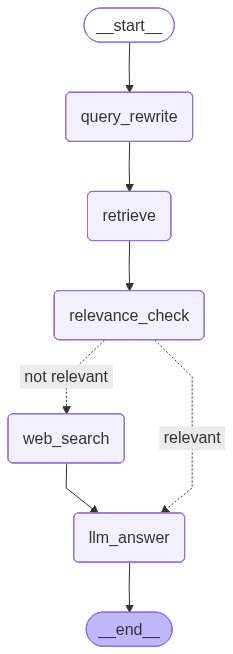

In [31]:
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)


# 5. Graph Execution

In [25]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid
from langchain_core.messages import HumanMessage

config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

inputs = GraphState(question=[HumanMessage(content="What is DeepSeek-R1-Zero?")])
invoke_graph(app, inputs, config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================

What is the DeepSeek-R1-Zero technology?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>Performance of DeepSeek-R1-Zero Figure 2 depicts the performance trajectory of DeepSeek-R1-Zero on the AIME 2024 benchmark throughout the RL training process. As illustrated, DeepSeek-R1-Zero demonstrates a steady and consistent enhancement in performance as the RL training advances. Notably, the</content><source>data/Deepseek-r1.pdf</source><page>7</page></document>
<document><content>the performance of DeepSeek-R1-Zero can be further augmented through the application of majority voting. For example, when majority voting is employed on the AIME benchmark, DeepSeek-R1-Zero’s performance escalates from 71.0% to 86.7%, thereby exceeding the performance of OpenAI-o1-0912. The</content><source>data/Deepseek-r1.pdf</source><page>8</page></document>
<document><content>To train DeepSeek-R1-Zero, we begin by designing a straightforward template that guides the base model to adhere to our specifie

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
yes


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
DeepSeek-R1-Zero is a reinforcement learning (RL) based model designed to enhance reasoning abilities without relying on any supervised fine-tuning or cold-start data. It autonomously improves its reasoning capabilities through pure RL, demonstrating behaviors such as self-verification, reflection, and generating long chains of thought (CoTs). During training, it shows significant performance gains on reasoning benchmarks like AIME 2024, improving pass@1 scores from 15.6% to 71.0%, and further to 86.7% with majority voting. It represents a milestone by validating that large language models' reasoning can be incentivized purely through RL.

**Source**  
- data/Deepseek-r1.pdf (pages 4, 5, 7, 8, 9, 17)
('user', 'What is the DeepSeek-R1-Zero technology?')
('assistant', "DeepSeek-R1-Zero is a reinforcement learning (RL) based model designed to enhance reasoning abilities without relying on any supervised fine-

In [24]:
stream_graph(app, inputs, config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
What is DeepSeek-R1-Zero technology, and what are its operational mechanisms?What is DeepSeek-R1-Zero technology, and what are its operational mechanisms?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"score":"yes"}

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
DeepSeek-R1-Zero is a first-generation reasoning model trained purely via large-scale reinforcement learning (RL) without any supervised fine-tuning or cold-start data. It autonomously enhances its reasoning abilities by generating long chains of thought (CoTs), self-verification, and reflection. Training uses a template that requires the model to produce a reasoning process before the final answer, enabling effective learning and generalization through RL alone. This approach significantly improves performance on reasoning benchmarks, for example, increasing pass@1 on AIME 2024 from 15.6% to 71.0%. DeepSeek-R1-Zero demonstrates that large language models' reasoning can be incentivized purely through RL.

**Source**  
- data/Deepseek-r1.pdf (pages 2, 4, 5, 7, 8)

In [26]:
inputs = GraphState(question=[HumanMessage(content="what is CeADAR, Ireland?")])
invoke_graph(app, inputs, config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================

What is the CeADAR initiative in Ireland?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>- Accuracy rewards: The accuracy reward model evaluates whether the response is correct. For example, in the case of math problems with deterministic results, the model is required to provide the final answer in a specified format (e.g., within a box), enabling reliable rule-based verification of</content><source>data/Deepseek-r1.pdf</source><page>7</page></document>
<document><content>the query is in a language other than English or Chinese. We aim to address this limitation in future updates.</content><source>data/Deepseek-r1.pdf</source><page>17</page></document>
<document><content>- Language Mixing: DeepSeek-R1 is currently optimized for Chinese and English, which may result in language mixing issues when handling queries in other languages. For instance, DeepSeek-R1 might use English for reasoning and responses, even if the query is in a language other than English or</content><sourc

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
no

🔄 Node: web_search 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
<document><title>CeADAR – HCAIM</title><url>https://humancentered-ai.eu/ceadar/</url><content>CeADAR - Ireland's Centre for Applied AI. ## CeADAR. CeADAR is Ireland’s national center for applied AI. It is a market-focused technology center that drives the accelerated research, development, and deployment of AI and data analytics technology and innovation into businesses. CeADAR is headquartered in University College Dublin and is the bridge between the worlds of applied research in AI and data analytics and their commercial deployment. ## Contacts.</content><raw>[Skip to content](#content)

* [About](#)
  + [Mission](https://humancentered-ai.eu/mission/)
  + [Consortium](https://humancentered-ai.eu/consortium/)
* [The Master’s Programme](#)
  + [About the Programme](https://humancentered-ai.eu/about-the-programme/)
  + [Pro

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
CeADAR is Ireland’s national centre for applied AI, headquartered at University College Dublin. It is a market-focused, not-for-profit technology centre that drives accelerated research, development, and deployment of AI, machine learning, and data analytics innovations into businesses. CeADAR supports start-ups, SMEs, and large organizations in adopting AI by providing AI strategies, prototypes, proofs of concept, market-ready solutions, training programs, funding support, and ecosystem networking. It also operates as a European Digital Innovation Hub (EDIH) offering fully discounted AI services to enterprises with under 3,000 staff and public sector organizations in Ireland. CeADAR maintains an extensive catalogue of technology demonstrators and hosts events to foster a thriving data analytics ecosystem.

**Source**  
- https://ceadar.ie/ (multiple pages)  
- https://humancentered-ai.eu/ceadar/  
- https

In [34]:
inputs = GraphState(question=[HumanMessage(content="What is value of QwQ-32B-Preview's AIME 2024 pass@1?")])
invoke_graph(app, inputs, config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================

What is the pass@1 value for QwQ-32B-Preview's AIME 2024?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>pass@1 = 1 / k * Σ (pi), where pi denotes the correctness of the i-th response. This method provides more reliable performance estimates. For AIME 2024, we also report consensus (majority vote) results (Wang et al., 2022) using 64 samples, denoted as cons@64.

1https://aider.chat</content><source>data/Deepseek-r1.pdf</source><page>13</page></document>
<document><content>During training, DeepSeek-R1-Zero naturally emerged with numerous powerful and interesting reasoning behaviors. After thousands of RL steps, DeepSeek-R1-Zero exhibits super performance on reasoning benchmarks. For instance, the pass@1 score on AIME 2024 increases from 15.6% to 71.0%, and with</content><source>data/Deepseek-r1.pdf</source><page>4</page></document>
<document><content>as the RL training advances. Notably, the average pass@1 score on AIME 2024 shows a significant increase, jumping from an initial 15.6% to an i

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
yes


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
The pass@1 value for QwQ-32B-Preview on AIME 2024 is 39.2%.

**Source:**
- data/Deepseek-r1.pdf (page 14)
('user', "What is the pass@1 value for QwQ-32B-Preview's AIME 2024?")
('assistant', 'The pass@1 value for QwQ-32B-Preview on AIME 2024 is 39.2%.\n\n**Source:**\n- data/Deepseek-r1.pdf (page 14)')


In [ ]:
inputs = GraphState(question=[HumanMessage(content="How does DeepSeek-R1-Zero use reinforcement learning?")])
invoke_graph(app, inputs, config["query_rewrite", "llm_answer"])

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================

In what ways does DeepSeek-R1-Zero implement reinforcement learning techniques?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>In this work, we share our journey in enhancing model reasoning abilities through reinforcement learning. DeepSeek-R1-Zero represents a pure RL approach without relying on cold-start data, achieving strong performance across various tasks. DeepSeek-R1 is more powerful, leveraging cold-start data</content><source>data/Deepseek-r1.pdf</source><page>17</page></document>
<document><content>After fine-tuning DeepSeek-V3-Base on the cold start data, we apply the same large-scale reinforcement learning training process as employed in DeepSeek-R1-Zero. This phase focuses on enhancing the model’s reasoning capabilities, particularly in reasoning-intensive tasks such as coding,</content><source>data/Deepseek-r1.pdf</source><page>11</page></document>
<document><content>We introduce our first-generation reasoning models, DeepSeek-R1-Zero and DeepSeek-R1. DeepSeek-R1-Zero, a model trained via large-sc

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
yes


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
DeepSeek-R1-Zero implements reinforcement learning (RL) techniques by training purely through large-scale RL without any supervised fine-tuning or cold-start data. It focuses on self-evolution, enabling the model to develop reasoning capabilities such as self-verification, reflection, and generating long chains of thought (CoTs). The RL process involves thousands of steps, during which the model naturally learns to solve reasoning tasks with increased thinking time, significantly improving performance on reasoning benchmarks.

**Source:**
- data/Deepseek-r1.pdf (pages 2, 4, 5, 6, 9, 17)
('user', 'In what ways does DeepSeek-R1-Zero implement reinforcement learning techniques?')
('assistant', 'DeepSeek-R1-Zero implements reinforcement learning (RL) techniques by training purely through large-scale RL without any supervised fine-tuning or cold-start data. It focuses on self-evolution, enabling the model to de

In [57]:
# outputs = app.get_state(config).values
# outputs